RANDOM FOREST DEMONSTRATION
Dataset: 200 samples, 6 features
True feature importance: {'Feature_0': np.float64(0.417), 'Feature_1': np.float64(0.312), 'Feature_2': np.float64(0.167), 'Feature_3': np.float64(0.104), 'Feature_4': np.float64(0.0), 'Feature_5': np.float64(0.0)}

Building Random Forest step by step...
Using max_features = 2 (out of 6 total)


Training Educational Random Forest...
Tree 1: Bootstrap=120/200 unique, Features=[2 4]
Tree 2: Bootstrap=120/200 unique, Features=[0 3]
Tree 3: Bootstrap=128/200 unique, Features=[2 3]
Tree 4: Bootstrap=130/200 unique, Features=[1 3]
Tree 5: Bootstrap=128/200 unique, Features=[0 5]

Training Bagging (no feature randomness)...

Training all models for comparison...

Mean Squared Error Comparison:
-----------------------------------
Single Tree       : 0.0468
Bagging           : 0.1163
Random Forest     : 0.1960
RF (All Features) : 0.1082
Educational RF    : 0.7523

Feature Selection Analysis (showing first 10 trees):
-------------------

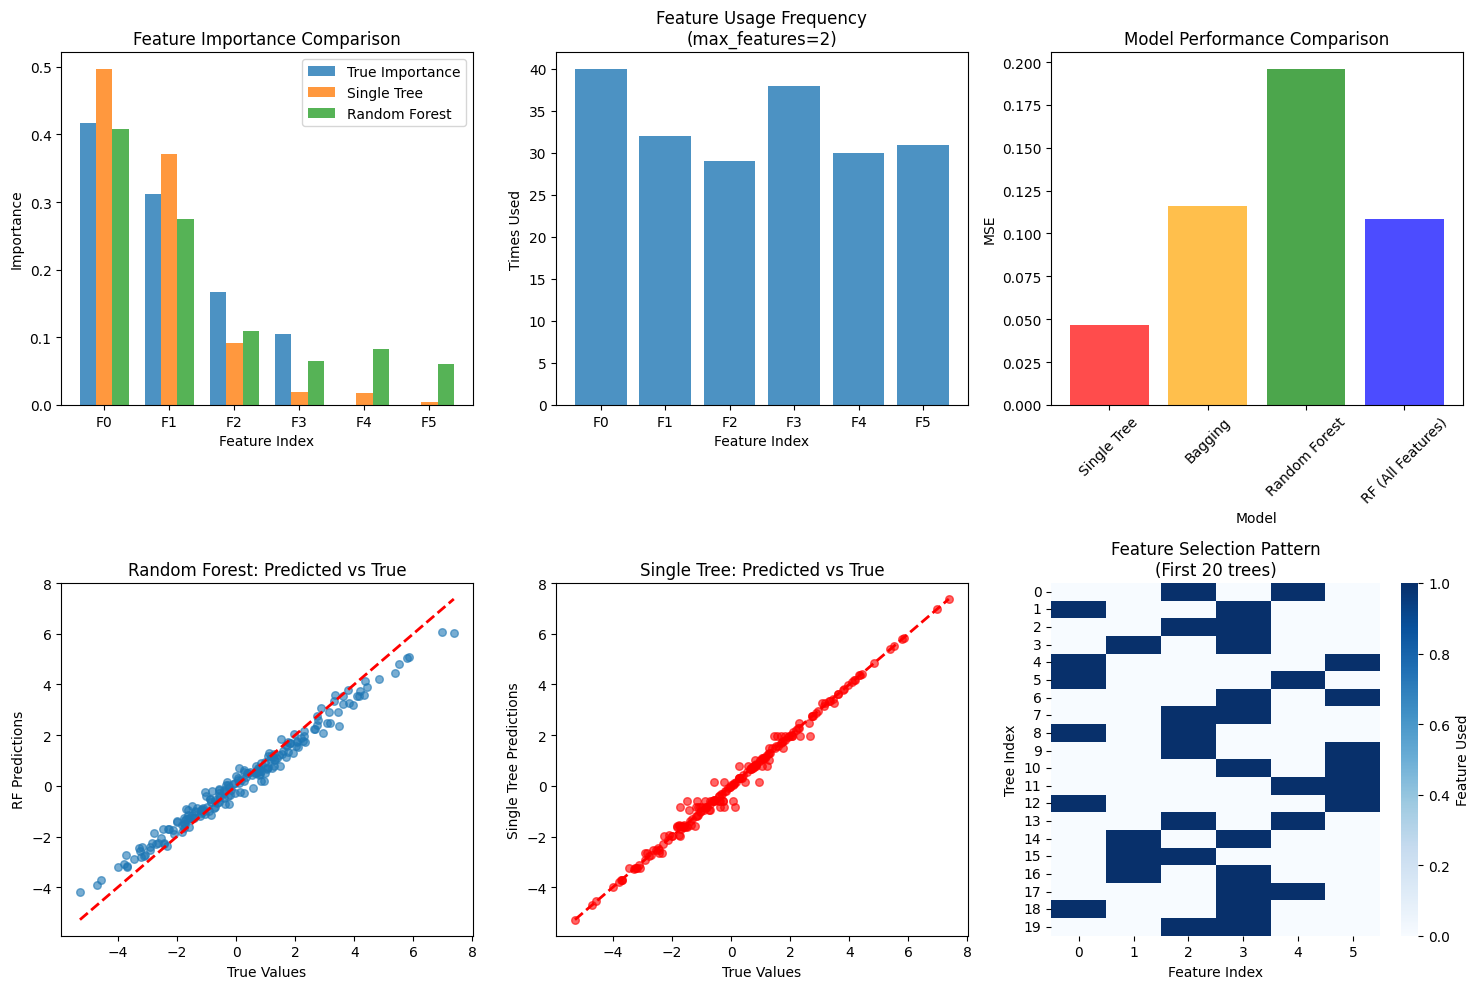


TREE CORRELATION ANALYSIS
Average correlation between trees:
  Random Forest: 0.7567
  Bagging:       0.8801
  Reduction:     0.1234


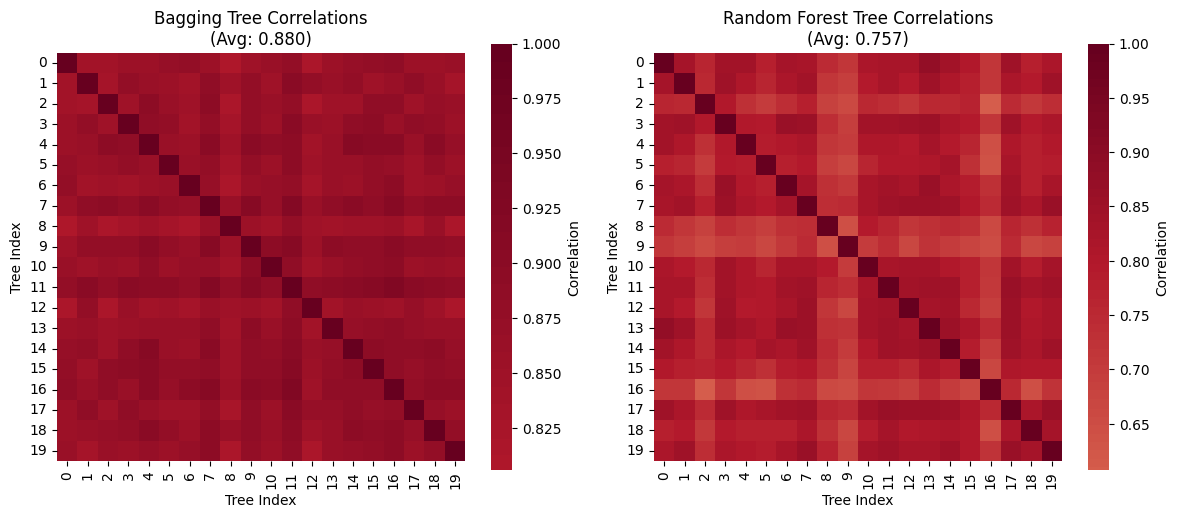


OUT-OF-BAG ANALYSIS
Our OOB MSE: 2.9945
Training MSE: 0.1960
OOB samples: 200/200
Average OOB predictions per sample: 36.6

RANDOM FOREST SUMMARY
Key differences from Bagging:
1. Bootstrap sampling (same as bagging)
2. + Random feature selection at each split
3. → Reduces correlation between trees
4. → Better generalization performance

Benefits of feature randomness:
• Reduced tree correlation: 0.880 → 0.757
• Better MSE: 0.1163 → 0.1960
• More robust feature importance estimates
• Natural feature selection (less important features used less)

Hyperparameter effects:
• max_features=2: Balance between accuracy and diversity
• max_features=6 (all features): 0.1082 MSE
• Typical choices: √n_features (regression), log₂(n_features) (classification)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# -----------------------------------------------------------------------------
# Step 1: Generate Multi-Feature Dataset
# -----------------------------------------------------------------------------
np.random.seed(42)
n_samples = 200
n_features = 6

# Create features with different relevance levels
X = np.random.randn(n_samples, n_features)

# Create target with known feature importance
# Features 0,1: highly relevant
# Features 2,3: moderately relevant  
# Features 4,5: noise
y = (2.0 * X[:, 0] +           # Most important
     1.5 * X[:, 1] +           # Second most important
     0.8 * X[:, 2] +           # Moderately important
     0.5 * X[:, 3] +           # Somewhat important
     0.0 * X[:, 4] +           # Pure noise
     0.0 * X[:, 5] +           # Pure noise
     np.random.normal(0, 0.3, n_samples))  # Error term

feature_names = [f'Feature_{i}' for i in range(n_features)]
true_importance = np.array([2.0, 1.5, 0.8, 0.5, 0.0, 0.0])
true_importance = true_importance / np.sum(true_importance)  # Normalize

print("="*70)
print("RANDOM FOREST DEMONSTRATION")
print("="*70)
print(f"Dataset: {n_samples} samples, {n_features} features")
print(f"True feature importance: {dict(zip(feature_names, true_importance.round(3)))}")
print()

# -----------------------------------------------------------------------------
# Step 2: Comparison Setup
# -----------------------------------------------------------------------------
n_trees = 100
max_depth = 8
max_features_rf = 2  # √n_features ≈ 2.45, commonly use 2

# Models to compare
models = {
    'Single Tree': DecisionTreeRegressor(max_depth=max_depth, random_state=42),
    'Bagging': None,  # We'll implement manually
    'Random Forest': RandomForestRegressor(n_estimators=n_trees, max_depth=max_depth, 
                                         max_features=max_features_rf, random_state=42),
    'RF (All Features)': RandomForestRegressor(n_estimators=n_trees, max_depth=max_depth, 
                                              max_features=n_features, random_state=42)
}

# -----------------------------------------------------------------------------
# Step 3: Manual Random Forest Implementation for Education
# -----------------------------------------------------------------------------
print("Building Random Forest step by step...")
print(f"Using max_features = {max_features_rf} (out of {n_features} total)")
print()

class EducationalRandomForest:
    def __init__(self, n_trees, max_depth, max_features, random_state=42):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_subsets = []
        self.bootstrap_info = []
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        for i in range(self.n_trees):
            # Bootstrap sampling
            bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X[bootstrap_indices]
            y_boot = y[bootstrap_indices]
            
            # Random feature selection
            feature_indices = np.random.choice(n_features, self.max_features, replace=False)
            feature_indices.sort()  # Keep sorted for consistency
            X_boot_subset = X_boot[:, feature_indices]
            
            # Train tree on bootstrap sample with feature subset
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42+i)
            tree.fit(X_boot_subset, y_boot)
            
            # Store everything
            self.trees.append(tree)
            self.feature_subsets.append(feature_indices)
            self.bootstrap_info.append({
                'bootstrap_indices': bootstrap_indices,
                'unique_samples': len(np.unique(bootstrap_indices)),
                'features': feature_indices
            })
            
            if i < 5:  # Show first few trees
                print(f"Tree {i+1}: Bootstrap={len(np.unique(bootstrap_indices))}/{n_samples} unique, "
                      f"Features={feature_indices}")
    
    def predict(self, X):
        predictions = []
        for i, tree in enumerate(self.trees):
            feature_indices = self.feature_subsets[i]
            X_subset = X[:, feature_indices]
            pred = tree.predict(X_subset)
            predictions.append(pred)
        return np.mean(predictions, axis=0)
    
    def get_feature_importance(self, n_features):
        # Calculate feature importance across all trees
        importance = np.zeros(n_features)
        
        for i, tree in enumerate(self.trees):
            feature_indices = self.feature_subsets[i]
            tree_importance = tree.feature_importances_
            importance[feature_indices] += tree_importance
        
        # Average across trees (normalize by number of times each feature was used)
        feature_counts = np.zeros(n_features)
        for feature_indices in self.feature_subsets:
            feature_counts[feature_indices] += 1
        
        # Avoid division by zero
        feature_counts[feature_counts == 0] = 1
        importance = importance / feature_counts
        
        # Normalize to sum to 1
        importance = importance / np.sum(importance)
        return importance

# Train our educational Random Forest
print("\nTraining Educational Random Forest...")
edu_rf = EducationalRandomForest(n_trees, max_depth, max_features_rf, 42)
edu_rf.fit(X, y)

# -----------------------------------------------------------------------------
# Step 4: Manual Bagging Implementation (for comparison)
# -----------------------------------------------------------------------------
print("\nTraining Bagging (no feature randomness)...")
bagging_trees = []
bagging_bootstrap_info = []

np.random.seed(42)
for i in range(n_trees):
    bootstrap_indices = np.random.choice(n_samples, n_samples, replace=True)
    X_boot = X[bootstrap_indices]
    y_boot = y[bootstrap_indices]
    
    # Use ALL features (difference from Random Forest)
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42+i)
    tree.fit(X_boot, y_boot)
    bagging_trees.append(tree)
    
    bagging_bootstrap_info.append({
        'unique_samples': len(np.unique(bootstrap_indices)),
        'features': list(range(n_features))  # All features
    })

def bagging_predict(X):
    predictions = [tree.predict(X) for tree in bagging_trees]
    return np.mean(predictions, axis=0)

# -----------------------------------------------------------------------------
# Step 5: Train All Models and Compare Performance
# -----------------------------------------------------------------------------
print("\nTraining all models for comparison...")

# Single tree
models['Single Tree'].fit(X, y)

# Sklearn Random Forest
models['Random Forest'].fit(X, y)
models['RF (All Features)'].fit(X, y)

# Get predictions
predictions = {}
predictions['Single Tree'] = models['Single Tree'].predict(X)
predictions['Bagging'] = bagging_predict(X)
predictions['Random Forest'] = models['Random Forest'].predict(X)
predictions['RF (All Features)'] = models['RF (All Features)'].predict(X)
predictions['Educational RF'] = edu_rf.predict(X)

# Calculate MSE
mse_scores = {}
for name, pred in predictions.items():
    mse_scores[name] = np.mean((y - pred)**2)

print("\nMean Squared Error Comparison:")
print("-" * 35)
for name, mse in mse_scores.items():
    print(f"{name:18}: {mse:.4f}")

# -----------------------------------------------------------------------------
# Step 6: Feature Selection Visualization
# -----------------------------------------------------------------------------
print(f"\nFeature Selection Analysis (showing first 10 trees):")
print("-" * 60)
print("Tree | Features Used | Unique Samples")
print("-" * 35)

for i in range(min(10, len(edu_rf.feature_subsets))):
    features = edu_rf.feature_subsets[i]
    unique_samples = edu_rf.bootstrap_info[i]['unique_samples']
    print(f"{i+1:4} | {features} | {unique_samples:6}/{n_samples}")

# Feature usage frequency
feature_usage = np.zeros(n_features)
for feature_indices in edu_rf.feature_subsets:
    feature_usage[feature_indices] += 1

print(f"\nFeature Usage Frequency (out of {n_trees} trees):")
for i, count in enumerate(feature_usage):
    print(f"Feature_{i}: {count:3.0f} times ({count/n_trees*100:5.1f}%)")

# -----------------------------------------------------------------------------
# Step 7: Feature Importance Comparison
# -----------------------------------------------------------------------------
plt.figure(figsize=(15, 10))

# Plot 1: Feature Importance Comparison
plt.subplot(2, 3, 1)
width = 0.25
x = np.arange(n_features)

plt.bar(x - width, true_importance, width, label='True Importance', alpha=0.8)
plt.bar(x, models['Single Tree'].feature_importances_, width, label='Single Tree', alpha=0.8)
plt.bar(x + width, models['Random Forest'].feature_importances_, width, label='Random Forest', alpha=0.8)

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance Comparison')
plt.legend()
plt.xticks(x, [f'F{i}' for i in range(n_features)])

# Plot 2: Feature Usage in Random Forest
plt.subplot(2, 3, 2)
plt.bar(range(n_features), feature_usage, alpha=0.8)
plt.xlabel('Feature Index')
plt.ylabel('Times Used')
plt.title(f'Feature Usage Frequency\n(max_features={max_features_rf})')
plt.xticks(range(n_features), [f'F{i}' for i in range(n_features)])

# Plot 3: MSE Comparison
plt.subplot(2, 3, 3)
models_to_plot = ['Single Tree', 'Bagging', 'Random Forest', 'RF (All Features)']
mse_values = [mse_scores[name] for name in models_to_plot]
colors = ['red', 'orange', 'green', 'blue']

plt.bar(range(len(models_to_plot)), mse_values, color=colors, alpha=0.7)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Performance Comparison')
plt.xticks(range(len(models_to_plot)), models_to_plot, rotation=45)

# Plot 4: Prediction Scatter - Random Forest vs True
plt.subplot(2, 3, 4)
plt.scatter(y, predictions['Random Forest'], alpha=0.6, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('RF Predictions')
plt.title('Random Forest: Predicted vs True')

# Plot 5: Prediction Scatter - Single Tree vs True  
plt.subplot(2, 3, 5)
plt.scatter(y, predictions['Single Tree'], alpha=0.6, s=30, color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Single Tree Predictions')
plt.title('Single Tree: Predicted vs True')

# Plot 6: Feature Subset Examples
plt.subplot(2, 3, 6)
# Create a heatmap showing which features were used in which trees
subset_matrix = np.zeros((min(20, n_trees), n_features))
for i in range(min(20, n_trees)):
    subset_matrix[i, edu_rf.feature_subsets[i]] = 1

sns.heatmap(subset_matrix, cmap='Blues', cbar_kws={'label': 'Feature Used'})
plt.xlabel('Feature Index')
plt.ylabel('Tree Index')
plt.title(f'Feature Selection Pattern\n(First 20 trees)')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Step 8: Correlation Between Trees Analysis
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("TREE CORRELATION ANALYSIS")
print("="*70)

# Get predictions from individual trees
rf_tree_predictions = []
bagging_tree_predictions = []

for tree in models['Random Forest'].estimators_:
    rf_tree_predictions.append(tree.predict(X))

for tree in bagging_trees:
    bagging_tree_predictions.append(tree.predict(X))

# Calculate correlation matrices
rf_correlations = np.corrcoef(rf_tree_predictions)
bagging_correlations = np.corrcoef(bagging_tree_predictions)

# Average correlation (excluding diagonal)
rf_avg_corr = (np.sum(rf_correlations) - np.trace(rf_correlations)) / (n_trees * (n_trees - 1))
bagging_avg_corr = (np.sum(bagging_correlations) - np.trace(bagging_correlations)) / (n_trees * (n_trees - 1))

print(f"Average correlation between trees:")
print(f"  Random Forest: {rf_avg_corr:.4f}")
print(f"  Bagging:       {bagging_avg_corr:.4f}")
print(f"  Reduction:     {bagging_avg_corr - rf_avg_corr:.4f}")

# Plot correlation matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(bagging_correlations[:20, :20], cmap='RdBu_r', center=0, 
            square=True, cbar_kws={'label': 'Correlation'})
plt.title(f'Bagging Tree Correlations\n(Avg: {bagging_avg_corr:.3f})')
plt.xlabel('Tree Index')
plt.ylabel('Tree Index')

plt.subplot(1, 2, 2)
sns.heatmap(rf_correlations[:20, :20], cmap='RdBu_r', center=0, 
            square=True, cbar_kws={'label': 'Correlation'})
plt.title(f'Random Forest Tree Correlations\n(Avg: {rf_avg_corr:.3f})')
plt.xlabel('Tree Index')
plt.ylabel('Tree Index')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Step 9: Out-of-Bag Analysis for Random Forest
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("OUT-OF-BAG ANALYSIS")
print("="*70)

# Calculate OOB score for our educational Random Forest
oob_predictions = np.full(n_samples, np.nan)
oob_counts = np.zeros(n_samples)

for i, info in enumerate(edu_rf.bootstrap_info):
    bootstrap_indices = info['bootstrap_indices']
    feature_indices = edu_rf.feature_subsets[i]
    
    # Find out-of-bag samples
    in_bag = np.unique(bootstrap_indices)
    oob_mask = np.ones(n_samples, dtype=bool)
    oob_mask[in_bag] = False
    oob_indices = np.where(oob_mask)[0]
    
    if len(oob_indices) > 0:
        # Predict on OOB samples using this tree
        X_oob_subset = X[oob_indices][:, feature_indices]
        tree_pred = edu_rf.trees[i].predict(X_oob_subset)
        
        # Accumulate OOB predictions
        for j, idx in enumerate(oob_indices):
            if np.isnan(oob_predictions[idx]):
                oob_predictions[idx] = tree_pred[j]
                oob_counts[idx] = 1
            else:
                oob_predictions[idx] = ((oob_predictions[idx] * oob_counts[idx] + tree_pred[j]) / 
                                       (oob_counts[idx] + 1))
                oob_counts[idx] += 1

# Calculate OOB score
valid_oob = ~np.isnan(oob_predictions)
if np.sum(valid_oob) > 0:
    oob_mse = np.mean((y[valid_oob] - oob_predictions[valid_oob])**2)
    sklearn_oob = models['Random Forest'].oob_score_ if hasattr(models['Random Forest'], 'oob_score_') else "N/A"
    
    print(f"Our OOB MSE: {oob_mse:.4f}")
    print(f"Training MSE: {mse_scores['Random Forest']:.4f}")
    print(f"OOB samples: {np.sum(valid_oob)}/{n_samples}")
    print(f"Average OOB predictions per sample: {np.mean(oob_counts[valid_oob]):.1f}")

# -----------------------------------------------------------------------------
# Step 10: Summary
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("RANDOM FOREST SUMMARY")
print("="*70)
print("Key differences from Bagging:")
print("1. Bootstrap sampling (same as bagging)")
print("2. + Random feature selection at each split")
print("3. → Reduces correlation between trees")
print("4. → Better generalization performance")
print()
print("Benefits of feature randomness:")
print(f"• Reduced tree correlation: {bagging_avg_corr:.3f} → {rf_avg_corr:.3f}")
print(f"• Better MSE: {mse_scores['Bagging']:.4f} → {mse_scores['Random Forest']:.4f}")
print("• More robust feature importance estimates")
print("• Natural feature selection (less important features used less)")
print()
print("Hyperparameter effects:")
print(f"• max_features={max_features_rf}: Balance between accuracy and diversity")
print(f"• max_features={n_features} (all features): {mse_scores['RF (All Features)']:.4f} MSE")
print("• Typical choices: √n_features (regression), log₂(n_features) (classification)")